# Compare Model with Experimental Results
The scenario is the venting of a multi-purpose duster (half-filled with difluoroethane)

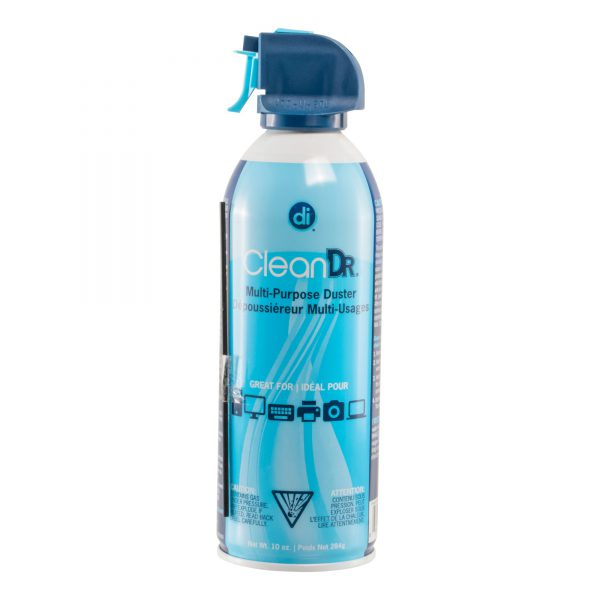

## First define model parameters
Found online by searching for property data for difluoroethane plus the parameters of the can. Estimated the heat and mass transfer coefficients.

In [1]:
#import needed packages
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt  
import pandas as pd

In [13]:
#model parameters for the venting of difluoroethane from a compressed container (all SI units)
lcan = 0.15 #150mm tall canister
dcan = 0.065 #diameter of can
harea = np.pi*lcan*dcan #150mm tall canister 65 mm diameter
marea = np.pi/4*dcan**2
Tsurr = 295 #surrounding temperature, K
Tref = 273 #reference temperature, K
factor = 0.9 #vent factor
gasConstant = 8.314 #J/mol/K
downstreamPressure = 12.2/14.5*1e5 #Pa, atmospheric pressure at test elevation approximately
gamma = 1.14 #ratio of specific heats of the gas
molecularWeight = 0.06605 #kg/mol
density = 2700 #kg/m3
CvVap = 59.58/gamma #J/mol/K, constant volume heat capacity
origmass = 10*0.0283495 #kg, amount initially present in the canister
Vol = lcan*np.pi/4*dcan**2#volume of the canister
#tuneable parameters
area = np.pi/4*0.0015**2 #orifice area for escaping gas,m2

In [14]:
origmass

0.283495

### Now specify the functions needed: 
- Venting through an orifice (mach number needed), 
- Saturated vapor pressure, 
- Equation of State,
- Derivatives of moles and temperature (based on energy and mole balances)

In [15]:
#specify mach number function
def mach(upstreamPressure):
  tau = 500
  transition = np.tanh((upstreamPressure-downstreamPressure)/tau)/2+0.5
  ratio = transition*upstreamPressure/downstreamPressure + (1-transition)*downstreamPressure/upstreamPressure
  multiplier = 1*transition-1*(1-transition)
  mach_abs=np.sqrt(2/(gamma-1)*(ratio**((gamma-1)/gamma)-1))
  return min(1.,mach_abs)*multiplier

def dndtvent(pressure,temperature): #rate of change of moles from a pressurized scenario
  #calculate the mach number
  machno = mach(pressure)
  if downstreamPressure>pressure:
    drivingPressure = downstreamPressure
  else:
    drivingPressure = pressure
  dndt = drivingPressure*area*factor*np.sqrt(gamma/(gasConstant*temperature*molecularWeight))*machno*(1+(gamma-1)/2*machno**2)**((gamma+1)/(2-2*gamma))
  return dndt

def psat(temperature): #saturated vapor pressure using Antione's equation
  constants = [4.23406,896.171,-34.714]
  return (10**(constants[0]-(constants[1]/(temperature+constants[2]))))*1e5
  
def pressure(molesLiq,molesVap,tempVap): #gas pressure from eos, assumed ideal
  return molesVap*gasConstant*tempVap/(Vol-molesLiq*molecularWeight/density) 

### Only model the gas phase with no heat transfer

In [16]:
def derivatives_gasonly(molesLiq,molesVap,tempVap):
  nout = dndtvent(pressure(molesLiq,molesVap,tempVap),tempVap)
  dndt = -nout
  dTdt = (nout*CvVap*(tempVap-Tref)-nout*CvVap*gamma*(tempVap-Tref))/(molesVap*CvVap)
  return [dndt,dTdt]

### Now simulate the simple example
Gas only without heat transfer

In [17]:
#pressure inside canister at room temperature
psat(Tsurr)/1e5*14.5 #psi, approximate based on antione equation

89.61976286014418

In [18]:
#initial values of variables
times=[0]
nliq = origmass/molecularWeight #moles
nV = [psat(Tsurr)*(Vol-nliq*molecularWeight/density)/(gasConstant*Tsurr)] #moles
TV = [Tsurr]

In [19]:
nosteps=15000; dt=0.01;

In [20]:
for i in tqdm(range(nosteps)):
  times.append(times[-1]+dt)
  #calculate derivatives and RK4 parameters
  ds1 = derivatives_gasonly(nliq,nV[-1],TV[-1])
  k1nv = dt*ds1[0]
  k1TV = dt*ds1[1]
  ds2 = derivatives_gasonly(nliq,nV[-1]+0.5*k1nv,TV[-1]+0.5*k1TV)
  k2nv = dt*ds2[0]
  k2TV = dt*ds2[1]
  ds3 = derivatives_gasonly(nliq,nV[-1]+0.5*k2nv,TV[-1]+0.5*k2TV)
  k3nv = dt*ds3[0]
  k3TV = dt*ds3[1]  
  ds4 = derivatives_gasonly(nliq,nV[-1]+k3nv,TV[-1]+k3TV)
  k4nv = dt*ds4[0]
  k4TV = dt*ds4[1]  
  dnvdt = (1.0 / 6.0)*(k1nv + 2 * k2nv + 2 * k3nv + k4nv)/dt
  dTVdt = (1.0 / 6.0)*(k1TV + 2 * k2TV + 2 * k3TV + k4TV)/dt
  nV.append(nV[-1]+dnvdt*dt)
  TV.append(TV[-1]+dTVdt*dt)

100%|██████████| 15000/15000 [00:00<00:00, 16834.15it/s]


### Now import the experimental data and compare
Temperature and weight data were taken as described here: https://youtu.be/v_9J51L-zsk. Weight data not digitized as of yet.

In [21]:
df = pd.read_csv('https://github.com/clint-bg/ventingVapor/raw/main/experimental.csv')
timeexp = df['Time'].to_numpy(); tempgas1=df['Gas1'].to_numpy(); tempgas2=df['Gas2'].to_numpy(); templiq=df['Liquid1'].to_numpy()

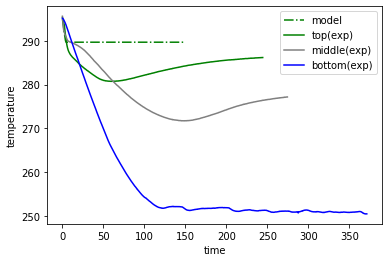

In [22]:
plt.plot(times,TV,'g-.')
plt.plot(timeexp,tempgas2+273.15,'g')
plt.plot(timeexp,tempgas1+273.15,'grey')
plt.plot(timeexp,templiq+273.15,'b')
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend(['model','top(exp)','middle(exp)','bottom(exp)'])
plt.show()

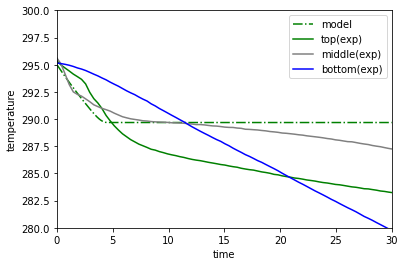

In [23]:
plt.plot(times,TV,'g-.')
plt.plot(timeexp,tempgas2+273.15,'g')
plt.plot(timeexp,tempgas1+273.15,'grey')
plt.plot(timeexp,templiq+273.15,'b')
plt.xlim([0, 30])
plt.ylim([280, 300])
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend(['model','top(exp)','middle(exp)','bottom(exp)'])
plt.show()

## Next Section

### Include in the model the two phases with heat transfer
- Additional parameters
- Heat transfer
- Psat and mass transfer functions
- Derivatives of the moles and temperature are evaluated for each phase

In [105]:
hvap = 22000 #heat of vaporation, J/mol
CvLiq = 118.4 #Cp,J/mol/K, assuming the constant volume heat capcity is very close to this
#tuneable parameters
hcv = 40 #convective heat transfer coefficient, J/m2/K
km = 0.05 #mass transfer coefficient, m/s

In [106]:
#include heat transfer
def heatIn(temperature): #heat into the volume
  return harea/2*hcv*(Tsurr-temperature) #1/2 factor for half the area for each of liq or vap

#include mass transfer between the liquid and the gas
def noutLiq(molesLiq,molesVap,tempLiq,tempVap): #mass transfer from the liquid surface
  return km*marea*(psat(tempLiq)/(gasConstant*tempLiq)-pressure(molesLiq,molesVap,tempVap)/(gasConstant*tempVap))

In [107]:
def derivatives(molesLiq,molesVap,tempLiq,tempVap):
  noutL = noutLiq(molesLiq,molesVap,tempLiq,tempVap); noutV = dndtvent(pressure(molesLiq,molesVap,tempVap),tempVap)
  dndtLiq = -noutL
  dndtVap = noutL-noutV
  dTdtLiq = (heatIn(tempLiq)-noutL*hvap+noutL*CvLiq*(tempLiq-Tref))/(molesLiq*CvLiq)
  dTdtVap = ((noutV-noutL)*CvVap*(tempVap-Tref)+noutL*CvVap*gamma*(tempLiq-Tref)-noutV*CvVap*gamma*(tempVap-Tref)+heatIn(tempVap))/(molesVap*CvVap)
  return [dndtLiq,dndtVap,dTdtLiq,dTdtVap]

### Now simulate the more complex vent scenario using a Runge Kutta 4th order integrator

In [108]:
#initial values of variables
times=[0]
nL = [origmass/molecularWeight]
nV = [psat(Tsurr)*(Vol-nL[0]*molecularWeight/density)/(gasConstant*Tsurr)]
TL = [Tsurr]; TV = [Tsurr]

In [109]:
nosteps=15000; dt=0.02;

In [110]:
for i in tqdm(range(nosteps)):
  times.append(times[-1]+dt)
  #calculate derivatives and RK4 parameters
  ds1 = derivatives(nL[-1],nV[-1],TL[-1],TV[-1])
  k1nl = dt*ds1[0]; k1nv = dt*ds1[1]
  k1Tl = dt*ds1[2]; k1TV = dt*ds1[3]
  ds2 = derivatives(nL[-1]+0.5*k1nl,nV[-1]+0.5*k1nv,TL[-1]+0.5*k1Tl,TV[-1]+0.5*k1TV)
  k2nl = dt*ds2[0]; k2nv = dt*ds2[1]
  k2Tl = dt*ds2[2]; k2TV = dt*ds2[3]
  ds3 = derivatives(nL[-1]+0.5*k2nl,nV[-1]+0.5*k2nv,TL[-1]+0.5*k2Tl,TV[-1]+0.5*k2TV)
  k3nl = dt*ds3[0]; k3nv = dt*ds3[1]
  k3Tl = dt*ds3[2]; k3TV = dt*ds3[3]  
  ds4 = derivatives(nL[-1]+k3nl,nV[-1]+k3nv,TL[-1]+k3Tl,TV[-1]+k3TV)
  k4nl = dt*ds4[0]; k4nv = dt*ds4[1]
  k4Tl = dt*ds4[2]; k4TV = dt*ds4[3]  
  dnldt = (1.0 / 6.0)*(k1nl + 2 * k2nl + 2 * k3nl + k4nl)/dt
  dnvdt = (1.0 / 6.0)*(k1nv + 2 * k2nv + 2 * k3nv + k4nv)/dt
  dTldt = (1.0 / 6.0)*(k1Tl + 2 * k2Tl + 2 * k3Tl + k4Tl)/dt
  dTVdt = (1.0 / 6.0)*(k1TV + 2 * k2TV + 2 * k3TV + k4TV)/dt
  nL.append(nL[-1]+dnldt*dt);nV.append(nV[-1]+dnvdt*dt)
  TL.append(TL[-1]+dTldt*dt);TV.append(TV[-1]+dTVdt*dt);

100%|██████████| 15000/15000 [00:01<00:00, 10783.25it/s]


### Compare the experimental to model result

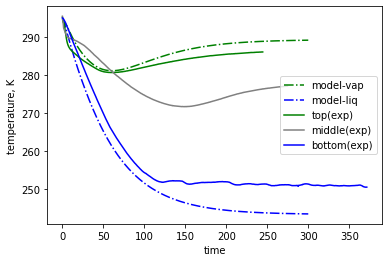

In [111]:
plt.plot(times,TV,'g-.')
plt.plot(times,TL,'b-.')
plt.plot(timeexp,tempgas2+273.15,'g')
plt.plot(timeexp,tempgas1+273.15,'grey')
plt.plot(timeexp,templiq+273.15,'b')
plt.xlabel('time')
plt.ylabel('temperature, K')
plt.legend(['model-vap','model-liq','top(exp)','middle(exp)','bottom(exp)'])
plt.show()

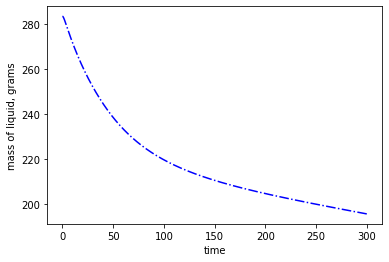

In [112]:
plt.plot(times,[each*molecularWeight*1000 for each in nL],'b-.')
plt.xlabel('time')
plt.ylabel('mass of liquid, grams')
plt.show()

### Plot the vapor pressure versus the internal pressure

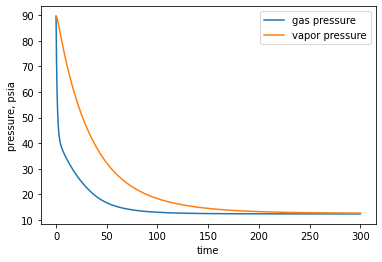

In [113]:
plt.plot(times,[pressure(nL[i],nV[i],each)/1e5*14.5 for i,each in enumerate(TV)])
plt.plot(times,[psat(each)/1e5*14.5 for each in TL])
plt.xlabel('time')
plt.ylabel('pressure, psia')
plt.legend(['gas pressure','vapor pressure'])
plt.show()

In [114]:
psat(TL[-1])/1e5*14.5

12.623151740576912